# Face Mask Detection



Here I am going to detect whether a person is wearing mask or not. I am focussing on only two classes that are 'face_with_mask' and face_no_mask'.

### Source Page
+ [Kaggle Source](https://www.kaggle.com/ayushimishra2809/face-mask-detection)


### Setup

1. Create a new [Anaconda](https://www.anaconda.com/products/individual) environment with Python 3.6 (not 3.7 or 3.8), keras, and tensorflow:
``` sh
> conda create -n <your_env_name> python=3.6 anaconda tensorflow keras
```
2. Install other missing packages:
``` sh
> conda install -c anaconda xlrd xlwt scikit-learn seaborn
> conda install mtcnn ipyparallel
> pip install python-opencv
```
3. That's all for now!

## Importing Libraries

In [107]:
import numpy as np 
import pandas as pd 
import os
import urllib
import matplotlib.pyplot as plt
import cv2                                 # opencv-python installed with 'pip'
import matplotlib.patches as patches
import tensorflow as tf                    # TensorFlow installed with 'pip'
import keras
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, load_model        # keras is only compatible with python 3.6 or lower
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import sklearn
from sklearn.preprocessing import LabelEncoder
from mtcnn.mtcnn import MTCNN

In [60]:
# pip install mtcnn

In [61]:
# from mtcnn.mtcnn import MTCNN

# Loading datasets

+ [Face Mask Detection Dataset (Kaggle)](https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset)

In [62]:
# images=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images")
# annotations=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations")
# train=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/train.csv"))
# submission=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/submission.csv"))
notebook_dir = !pwd
notebook_dir = notebook_dir[0]
root_dir = os.path.abspath(os.path.join(notebook_dir, os.pardir))
data_dir = os.path.join(root_dir, 'data')
images_dir = os.path.join(data_dir, 'images/kaggle')
annotations_dir = os.path.join(data_dir, 'annotations')


train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
KAGGLE_GIT_DIR = "https://github.com/brtonnies/face-mask-detection/blob/data-branch/data/images"

In [63]:
print(len(train))
train

15412


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask
...,...,...,...,...,...,...
15407,1894.jpg,437,121,907,644,face_with_mask
15408,1894.jpg,557,363,876,636,mask_surgical
15409,1894.jpg,411,3,940,325,hat
15410,3216.png,126,69,409,463,face_with_mask


In [64]:
print(len(submission))
submission.head()

8142


,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN


In [65]:
NUM_IMAGES = len(os.listdir(images_dir))

## We have 6024 images.  There's an extra file in the directory we'll ignore

In [66]:
image_formats = ['jpg', 'jpeg', 'png']
a = os.listdir(images_dir)
a = [img for img in a if img.split(".")[-1] in image_formats]
b = os.listdir(annotations_dir)
a.sort()
b.sort()

In [67]:
print(len(b),len(a))

4326 6024


## The Original Source Used a Supervised Learning Model

In [68]:
train_images=a[1698:]
test_images=a[:1698]


Just to prove there's at least one image

In [71]:
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)]
train.sort_values('name',axis=0,inplace=True)

/Users/brtonnies/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[[112, 113, 262, 307]]


/Users/brtonnies/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


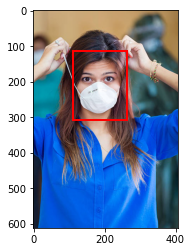

In [72]:
bbox=[]
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"]=bbox  
def get_boxes(id):
    boxes=[]
    for i in train[train["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes
print(get_boxes(train_images[3]))
image=train_images[3]

img=plt.imread(os.path.join(images_dir,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()


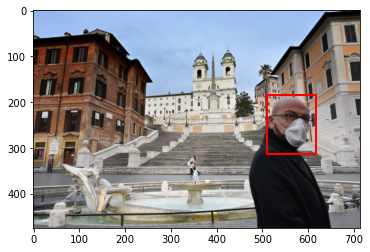

In [73]:
image=train_images[5]

img=plt.imread(os.path.join(images_dir,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()


<BarContainer object of 2 artists>

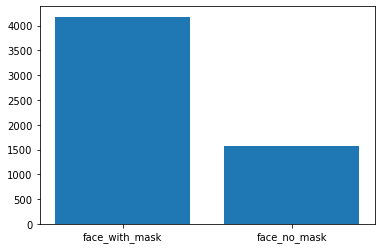

In [74]:
plt.bar(['face_with_mask','face_no_mask'],train.classname.value_counts())

# Creating Training Data

In [75]:
img_size=50
data=[]
# path='../data/images/'
path = images_dir
def create_data():
    for i in range(len(train)):
        arr=[]
        for j in train.iloc[i]:
               arr.append(j)
        img_array = cv2.imread(os.path.join(images_dir, arr[0]), cv2.IMREAD_GRAYSCALE)
        crop_image = img_array[arr[2]:arr[4], arr[1]:arr[3]]
        new_img_array=cv2.resize(crop_image, (img_size, img_size))
        data.append([new_img_array, arr[5]])
        
        pct = i/len(train) * 100
        if pct % 5 == 0:
            print("Creating Training Data -- {}%".format(pct))
            
create_data()

len(train)

Creating Training Data -- 0.0%


5749

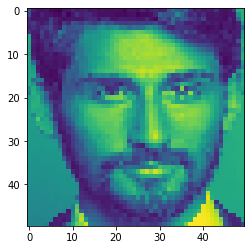

In [76]:
data[0][0]
plt.imshow(data[0][0])

In [77]:
len(data)

5749

In [78]:
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)

# print(y)
lbl=LabelEncoder()
y=lbl.fit_transform(y)
y.shape

(5749,)

In [79]:
x=np.array(x).reshape(-1,50,50,1)
x=tf.keras.utils.normalize(x,axis=1)
from keras.utils import to_categorical
y = to_categorical(y)
y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Model Fitting

In [117]:
# from keras.layers import LSTM
kernel_size = (3, 3)
image_shape = (50, 50, 3)

model = Sequential([
    Conv2D(
        100, 
        kernel_size, 
        input_shape=x.shape[1:], 
        activation='relu', 
        strides=2
    ),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, kernel_size, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    
    Dense(2, activation='softmax')
])


model_path = '../models/mnm/kaggle_relu_softmax_1e31e5_take2'
checkpoint_path = '../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint'

checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = False,
    mode = 'auto'
)

logger = CSVLogger(os.path.join(model_path, 'logs/training.csv'))

In [121]:
# NOTE: here's something cool - we can use checkpoints
#       to save/load the weights from previous model training
# if os.path.exists(checkpoint_path):
#     model.load_weights(os.path.join(checkpoint_path, 'variables/variables'))
    
# alternatively, we can load the whole model from the checkpoint state
if os.path.exists(checkpoint_path):
    model = load_model(checkpoint_path)


#  WARNING: THIS TAKES TIME -- USE THE COMPILED MODEL IF POSSIBLE
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x, y, epochs=30, batch_size=5, callbacks=[checkpoint, logger])
# model.save("../models/kaggle_relu_softmax_1e31e5_take2")

# kaggle_relu_softmax_1e31e5

Train on 5749 samples
Epoch 1/30
5740/5749 [============================>.] - ETA: 0s - loss: 0.3205 - acc: 0.8563
Epoch 00001: saving model to ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint/assets
5749/5749 [==============================] - 33s 6ms/sample - loss: 0.3202 - acc: 0.8563
Epoch 2/30
5745/5749 [============================>.] - ETA: 0s - loss: 0.2990 - acc: 0.8695
Epoch 00002: saving model to ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint/assets
5749/5749 [==============================] - 33s 6ms/sample - loss: 0.2990 - acc: 0.8694
Epoch 3/30
5740/5749 [============================>.] - ETA: 0s - loss: 0.2782 - acc: 0.8800
Epoch 00003: saving model to ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/kaggle_relu

5740/5749 [============================>.] - ETA: 0s - loss: 0.0649 - acc: 0.9740
Epoch 00023: saving model to ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint/assets
5749/5749 [==============================] - 35s 6ms/sample - loss: 0.0648 - acc: 0.9741
Epoch 24/30
5740/5749 [============================>.] - ETA: 0s - loss: 0.0645 - acc: 0.9761
Epoch 00024: saving model to ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint/assets
5749/5749 [==============================] - 35s 6ms/sample - loss: 0.0649 - acc: 0.9760
Epoch 25/30
5745/5749 [============================>.] - ETA: 0s - loss: 0.0611 - acc: 0.9777
Epoch 00025: saving model to ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoin

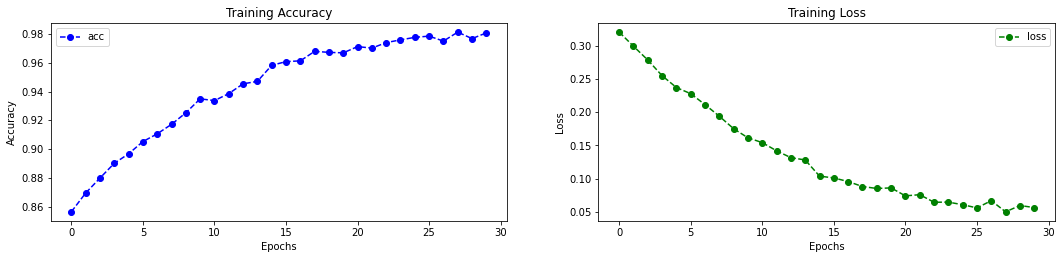

In [125]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(18,8))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
#     plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("Training Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'go--', label = "loss")
#     plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("Training Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()
    
plot_accuracy_loss(history)
# fig = plt.figure(figsize=(18,8))
# plt.plot(history.history['acc'],'ro--', label = "acc")
# plt.plot(history.history['loss'],'bo--', label = "loss")
# plt.title("Training Accuracy vs. Training Loss")
# plt.ylabel("Accuracy")
# plt.xlabel("Loss")


In [24]:
def get_face_bounds(img):

    detector = MTCNN()
    image = plt.imread(os.path.join(images_dir, img))
    faces = detector.detect_faces(image)
    img = np.array(img)
    print(faces)
    bounds = []
    img = np.array(image)
    bounding_box = faces[0]['box']
    keypoints = faces[0]['keypoints']
    for (x, y, w, h) in [face['box'] for  face in faces]:
        cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              19)
        cv2.circle(img,(keypoints['left_eye']), 2, (0,155,255), 19)
        cv2.circle(img,(keypoints['right_eye']), 2, (0,155,255), 19)
        cv2.circle(img,(keypoints['nose']), 2, (0,155,255), 19)
        cv2.circle(img,(keypoints['mouth_left']), 2, (0,155,255), 19)
        cv2.circle(img,(keypoints['mouth_right']), 2, (0,155,255), 19)
        plt.imshow(img)
        bounds.append(img)

    return bounds

[{'box': [441, 108, 341, 416], 'confidence': 0.9999905824661255, 'keypoints': {'left_eye': (502, 270), 'right_eye': (642, 228), 'nose': (559, 296), 'mouth_left': (534, 412), 'mouth_right': (670, 373)}}]


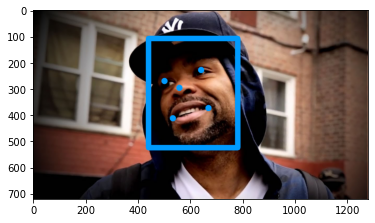

In [25]:
image = test_images[0]
bounding_boxes =  get_face_bounds(image)

[{'box': [66, 136, 31, 40], 'confidence': 0.9999638795852661, 'keypoints': {'left_eye': (86, 151), 'right_eye': (96, 152), 'nose': (95, 161), 'mouth_left': (84, 168), 'mouth_right': (93, 169)}}, {'box': [114, 135, 27, 32], 'confidence': 0.9999489784240723, 'keypoints': {'left_eye': (131, 146), 'right_eye': (140, 146), 'nose': (140, 154), 'mouth_left': (131, 160), 'mouth_right': (139, 160)}}, {'box': [479, 67, 55, 67], 'confidence': 0.9989905953407288, 'keypoints': {'left_eye': (489, 95), 'right_eye': (512, 94), 'nose': (496, 107), 'mouth_left': (489, 121), 'mouth_right': (512, 120)}}, {'box': [197, 130, 23, 31], 'confidence': 0.9981657862663269, 'keypoints': {'left_eye': (212, 144), 'right_eye': (219, 145), 'nose': (217, 153), 'mouth_left': (207, 156), 'mouth_right': (212, 157)}}, {'box': [447, 119, 12, 19], 'confidence': 0.9964094758033752, 'keypoints': {'left_eye': (449, 126), 'right_eye': (453, 127), 'nose': (447, 130), 'mouth_left': (448, 135), 'mouth_right': (451, 135)}}, {'box': 

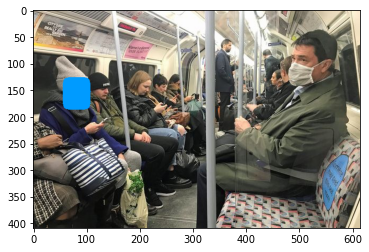

In [26]:
image = test_images[60]
bounding_boxes += get_face_bounds(image)

[{'box': [630, 176, 212, 266], 'confidence': 0.999250590801239, 'keypoints': {'left_eye': (682, 297), 'right_eye': (779, 297), 'nose': (718, 353), 'mouth_left': (681, 392), 'mouth_right': (754, 389)}}]


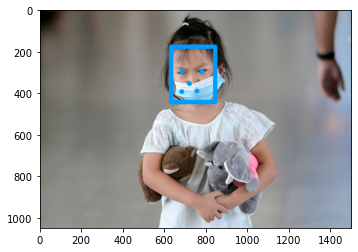

In [27]:
image = test_images[3]
bounding_boxes += get_face_bounds(image)